# Tutorial: More on linear models

In this tutorial, we will play more with linear regression models, including an illustration of the bias-variance tradeoff at the end.

## Goals:
* Regression with multiple predictors
* Using categorical predictors
* Simulating the bias-variance tradeoff

This lab draws from the content in Chapters 2 \& 3 of James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r."

--- 
# Getting started

Before we start, let's just get all the libraries loaded up front. This tutorial requires some new libraries we haven't worked with before. Uncomment the _install.packages_ lines if you do not already have all the packages already installed. 

In [2]:
# Libaries to install
#install.packages("glmnet")
#install.packages("matrixStats")
#install.packages("denoiseR")
#install.packages("gplots")
#install.packages("RColorBrewer")
#install.packages("plot3D") 
# install.packages("car") 
#install.packages("ISLR")

# Load the libraries
library(MASS)
library(glmnet)
library(tidyverse)
library(ggplot2)
library(matrixStats)
library(denoiseR)
library(gplots)
library(RColorBrewer)
library(plot3D) 
library(ISLR)


Because we will be generating random data here, let's set the random number generator seed. This will allow us to get the same results everytime we run the entire notebook.

In [3]:
# Set the random number generator seed
set.seed(2023)

---
# Regression with multiple predictors

<br>
In the examples we have done so far, we have only looked at models where p = 1. 

$$ Y_{medv} = \hat{\beta_0} + \hat{\beta_1}X_{lstat} + \epsilon $$

Now let us explore the case where p > 1. For this we will be using the `Cars93` dataset which is part of the `MASS` package. This dataset has information on the dimensions and weight ([among other things](https://www.rdocumentation.org/packages/MASS/versions/7.3-58.2/topics/Cars93)) for different types of cars.

Let's just look at the data along the dimensions of width, length, and weight.

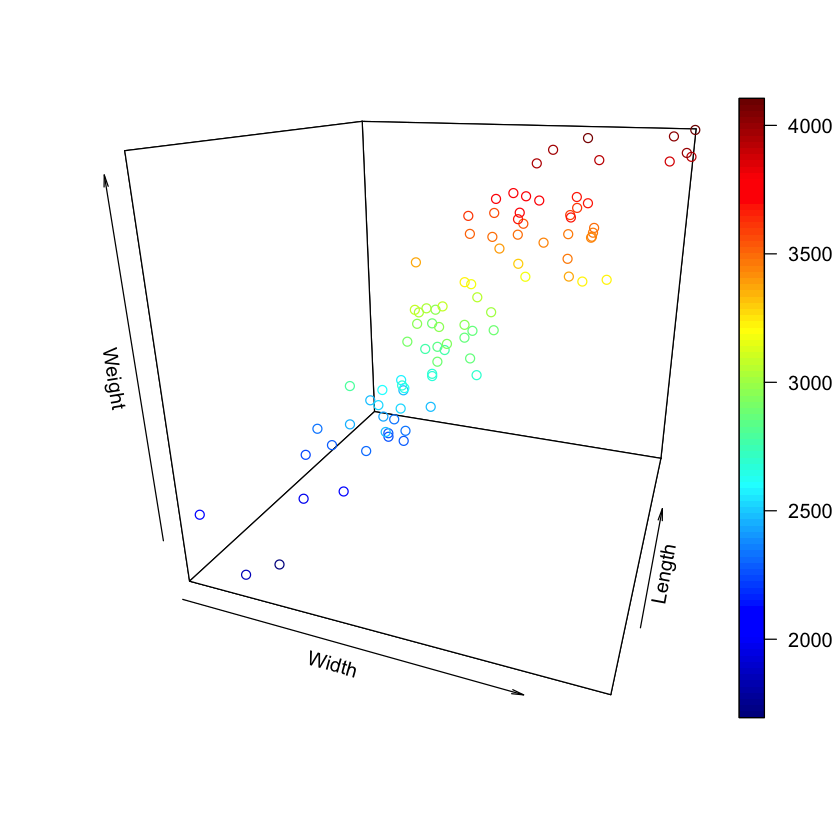

In [4]:

scatter3D(Cars93$Width, Cars93$Length, Cars93$Weight, 
          phi = 20, theta = 20, #phi controls tilt and theta controls angle
          xlab = "Width", ylab = "Length", zlab = "Weight")


Interpeting the 3 dimensional scatterplot is the same as interpreting a 2 dimensional plot. You want a "football" shaped clustering where changes in `Weight` follow changes in the other two variables. So here, as the width and length of the car increase, the weight of the car increases too.


So it looks like adding `Width` seems to also explain `Weight`. Let's confirm by fitting a linear model with `Width` and `Length` predicting `Weight`.

In [5]:
lm.fit = lm(Weight ~ Width + Length, data=Cars93)
summary(lm.fit)


Call:
lm(formula = Weight ~ Width + Length, data = Cars93)

Residuals:
    Min      1Q  Median      3Q     Max 
-546.05 -194.89  -45.85  189.58  579.58 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5999.519    540.622 -11.097  < 2e-16 ***
Width         102.156     13.281   7.692 1.75e-11 ***
Length         10.836      3.437   3.153   0.0022 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 274 on 90 degrees of freedom
Multiple R-squared:  0.7889,	Adjusted R-squared:  0.7842 
F-statistic: 168.1 on 2 and 90 DF,  p-value: < 2.2e-16


Let's say we wanted to estimate the _full model_ (i.e., use all the numeric variables in the `Cars93` data set to predict `Weight`). If you use the "." symbol in the `lm()` function call, it tells R to use all variables _but_ the one being predicted.

In [6]:
num_cols <- unlist(lapply(Cars93, is.numeric)) # find just the numeric columns
head(num_cols)

lm.fit=lm(Weight ~ ., 
          data = Cars93[,num_cols]) #using indexing to select columns
summary(lm.fit)

Manufacturer        Model         Type    Min.Price        Price    Max.Price 
       FALSE        FALSE        FALSE         TRUE         TRUE         TRUE


Call:
lm(formula = Weight ~ ., data = Cars93[, num_cols])

Residuals:
     Min       1Q   Median       3Q      Max 
-220.402  -70.076   -4.002   69.825  222.764 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         140.05133  658.01561   0.213  0.83213    
Min.Price           165.31369  266.93918   0.619  0.53792    
Price              -324.39700  532.71044  -0.609  0.54471    
Max.Price           161.71716  266.15830   0.608  0.54560    
MPG.city              8.59419    9.31530   0.923  0.35969    
MPG.highway         -20.22139    9.05965  -2.232  0.02912 *  
EngineSize          -54.32469   59.99456  -0.905  0.36860    
Horsepower            4.32739    0.90113   4.802 9.82e-06 ***
RPM                  -0.11785    0.05006  -2.354  0.02165 *  
Rev.per.mile         -0.11059    0.05473  -2.021  0.04751 *  
Fuel.tank.capacity   31.58016   11.17775   2.825  0.00629 ** 
Passengers          -12.18737   33.37579  -0.365  0.71620    
Length          

Let's just keep playing with the ways that you can run and query the model object. First, let's say you want to exclude some of the non-significant variables from the model. According to the coefficients table above, `EngineSize` and `Passengers` are not significant predictors when we run the full model. So we can remove them in two ways. 

First we can just train a new model with these variables excluded. You can do this by adding a `-` in front of the variable name after the tilde.

In [7]:
#excluding EngineSize and Passengers using "-"
lm.fit_new = lm(Weight ~ . -EngineSize -Passengers, data=Cars93[,num_cols]) 
summary(lm.fit_new)


Call:
lm(formula = Weight ~ . - EngineSize - Passengers, data = Cars93[, 
    num_cols])

Residuals:
     Min       1Q   Median       3Q      Max 
-237.809  -68.733   -1.621   68.685  227.473 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         147.72555  651.85150   0.227  0.82142    
Min.Price            75.96356  249.11030   0.305  0.76137    
Price              -147.95766  497.76892  -0.297  0.76722    
Max.Price            74.20151  248.91613   0.298  0.76656    
MPG.city              7.03821    9.10838   0.773  0.44245    
MPG.highway         -19.32891    8.75157  -2.209  0.03068 *  
Horsepower            3.86820    0.69431   5.571 5.02e-07 ***
RPM                  -0.08711    0.03597  -2.422  0.01819 *  
Rev.per.mile         -0.09151    0.05010  -1.826  0.07232 .  
Fuel.tank.capacity   29.29317   10.63264   2.755  0.00758 ** 
Length                5.43428    2.61187   2.081  0.04135 *  
Wheelbase            15.52055    6.25976   2.47

Alternatively we can just update the _lm.fit_ model that we estimated above by extracting those variables using the _update_ function.

In [8]:
# Or just update the existing model
lm.fit_new = update(lm.fit, ~ . -EngineSize -Passengers)
summary(lm.fit_new)


Call:
lm(formula = Weight ~ Min.Price + Price + Max.Price + MPG.city + 
    MPG.highway + Horsepower + RPM + Rev.per.mile + Fuel.tank.capacity + 
    Length + Wheelbase + Width + Turn.circle + Rear.seat.room + 
    Luggage.room, data = Cars93[, num_cols])

Residuals:
     Min       1Q   Median       3Q      Max 
-237.809  -68.733   -1.621   68.685  227.473 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         147.72555  651.85150   0.227  0.82142    
Min.Price            75.96356  249.11030   0.305  0.76137    
Price              -147.95766  497.76892  -0.297  0.76722    
Max.Price            74.20151  248.91613   0.298  0.76656    
MPG.city              7.03821    9.10838   0.773  0.44245    
MPG.highway         -19.32891    8.75157  -2.209  0.03068 *  
Horsepower            3.86820    0.69431   5.571 5.02e-07 ***
RPM                  -0.08711    0.03597  -2.422  0.01819 *  
Rev.per.mile         -0.09151    0.05010  -1.826  0.07232 .  
Fuel

Either way it's pretty easy to swap terms in and out of the model in R.

---
# Working with categorical (qualitative) predictors


So far we've been playing mostly with quantitative predictors. Let's now play with some categorical, i.e., qualitative predictors.

For this we will use the `Carseats` data set from the [car](https://cran.r-project.org/web/packages/car/car.pdf) package.

In [9]:
# First we will want to clear the workspace
rm(list=ls())

# Look at the Carseats dataset
# help(Carseats) # Uncomment to view documentation
names(Carseats)

[1] "Sales"       "CompPrice"   "Income"      "Advertising" "Population" 
 [6] "Price"       "ShelveLoc"   "Age"         "Education"   "Urban"      
[11] "US"

This data set consists of a data frame with 400 observations on the following 11 variables.

* **Sales:**  Unit sales (in thousands) at each location

* **CompPrice:** Price charged by competitor at each location

* **Income:**  Community income level (in thousands of dollars)

* **Advertising:** Local advertising budget for company at each location (in thousands of dollars)

* **Population:** Population size in region (in thousands)

* **Price:**  Price company charges for car seats at each site

* **ShelveLoc:** A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site

* **Age:** Average age of the local population

* **Education:** Education level at each location

* **Urban:**  A factor with levels No and Yes to indicate whether the store is in an urban or rural location

* **US:** A factor with levels No and Yes to indicate whether the store is in the US or not


Let's fit a model that predicts `Sales` from some of these variables. We will want to pay special attention to the `ShelveLoc` variable.

The below model includes all the individual predictors (using `.`), and also fits some interaction terms using the `:` between two variables.

In [10]:
lm.fit = lm(Sales ~ . + Income:Advertising + Price:Age, data = Carseats) 
summary(lm.fit)


Call:
lm(formula = Sales ~ . + Income:Advertising + Price:Age, data = Carseats)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9208 -0.7503  0.0177  0.6754  3.3413 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         6.5755654  1.0087470   6.519 2.22e-10 ***
CompPrice           0.0929371  0.0041183  22.567  < 2e-16 ***
Income              0.0108940  0.0026044   4.183 3.57e-05 ***
Advertising         0.0702462  0.0226091   3.107 0.002030 ** 
Population          0.0001592  0.0003679   0.433 0.665330    
Price              -0.1008064  0.0074399 -13.549  < 2e-16 ***
ShelveLocGood       4.8486762  0.1528378  31.724  < 2e-16 ***
ShelveLocMedium     1.9532620  0.1257682  15.531  < 2e-16 ***
Age                -0.0579466  0.0159506  -3.633 0.000318 ***
Education          -0.0208525  0.0196131  -1.063 0.288361    
UrbanYes            0.1401597  0.1124019   1.247 0.213171    
USYes              -0.1575571  0.1489234  -1.058 0.290729    
Inco

Let's look closer at the _ShelveLoc_ variable. Notice that the original variable had 3 levels. But R automatically recoded this into 2 binary variables: _ShelveLocGood_ and _ShelveLocMedium_.

You can see how r sets up this binarization using the _contrasts_ function.

In [14]:
contrasts(Carseats$ShelveLoc)

,Good,Medium
Bad,0,0
Good,1,0
Medium,0,1


Here, the `Shelveloc` value is "Bad" when both "Good" and "Medium" are 0. The value is "Good" when `Good = 1`, and is "Medium" when `Medium = 1` 

Thus the effect for "bad" shelving locations is included in the **intercept term** of the model. The coefficient for `ShelveLocGood` in the above output therefore represents the bump in sales associated with having "good" shelving locations compared to "bad" shelving locations, all other variables held constant. (And same thing for `ShelveLocMedium` -- this is the difference between "bad" and "medium" shelving locations.)

In this model, `ShelveLoc` is the only categorical variable that has more than 2 levels. But remember -- things get complicated if you have multiple categorical variables that have more than two terms. As we discussed in lecture, in those cases the intercept no longer corresponds to a single level of a categorical variable. So watch carefully how R redefines categorical variables.

---
# Simulating the bias-variance tradeoff

For the last part of this tutorial, let us return to the bias-variance tradeoff. Our goal will be to simulate data in order to show the tradeoff in action.

To do this we need to generate a data set that has a natural low-dimensional structure to it. Which means that if you have $p$ variables in $X$, because of correlations across variables, the true dimensionality of $X$ is $<p$.

You don't need to know the details of _how_ the data that we generate is low-dimensional (we will return to this issue when we talk about principal componenet models). For right now all you'll need to know is the concept of a matrix "rank". 

When we talk about a matrix's "rank" we mean essentially the number of independent columns in the matrix. If each column is linearly independent of every other column in $X$, then the rank of $X$, $k$, is $k=p$. We call this situation being "full rank". As $X$ gets greater correlational structure across variables (columns), the rank decreases. We say it is "low rank". 

For doing this we will use the _LRsim_ function in the _denoiseR_ libary that you loaded above. Let us write a simple function that will generate data by taking 4 inputs.

* $n$ = number of observations (rows)

* $p$ = number of features (columns)

* $k$ = rank of data 

* $s$ = signal-to-noise ratio

We will rely on something called singular value decomposition (SVD) to create a low rank data set. You don't need to know what SVD does at the moment. We will come back to this in later classes. For now, just trust us that it generates low rank, (i.e. intercorrelated) data.

In [11]:
make_data <- function(n,p,k,s){
  
  if (n < p){
    # If number of features is greater 
    # than number of observations, increase
    # observations for the PCA to work
    m=p
  } else {
    # Otheriwse use the input n
    m=n
  }
  
  if (p < k) {
    # Make full rank until p=k
    # degree_diff = k-p
    x = LRsim(m,p,p,s)$X
  } else {
    x = LRsim(m,p,k,s)$X
  }

  # Recover low-d components
  z = princomp(x)
  
  # Set the first k components to 1, otherwise 0
  if (p-k < 0){
    u = rep(10,p) #rnorm(p,mean=1,sd=0.5)
  } else {
    u = c(rep(10,k),matrix(0,nrow=1,ncol=p-k))
  }
  
  # Calculate the weights in the data space
  b = t(u %*% t(z$loadings))
  
  # In case we needed to set m=p for the 
  # PCA to work, take the first n observations
  # of x
  x = x[1:n,]
  
  # Generate your output
  y = x %*% b + rnorm(n)
  
  return(list(X=x, Y=y, B=b))
}

Pay attention to how we set up the relationship with $Y$. The vector $u$ only assigns strongest weights to the first $k$ components in $X$ in order to influence $Y$. So the dimensionality of our problem is approximately $k$.

Okay, now that we have our function for making data, let's take a look at what it returns for a 100 observations ($n$), 20 variables ($p$), a rank ($k$) of 5, and signal-to-noise ($s$) of 10. 

In [12]:
n = 500
p = 20
k = 10
s = 20

data = make_data(n,p,k,s)
summary(lm(Y ~ X, data = data))


Call:
lm(formula = Y ~ X, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.78569 -0.62726 -0.07531  0.59695  2.57939 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)    0.03523    0.04533   0.777   0.4375  
X1            24.41500   61.86812   0.395   0.6933  
X2            14.17653   44.10736   0.321   0.7480  
X3            17.62072   67.64961   0.260   0.7946  
X4          -110.45193   71.72453  -1.540   0.1242  
X5            32.11625   54.66273   0.588   0.5571  
X6           133.22155   66.01748   2.018   0.0442 *
X7           -86.10253   55.68913  -1.546   0.1227  
X8          -116.70388   67.10784  -1.739   0.0827 .
X9           108.78295   69.26610   1.571   0.1170  
X10           42.71434   59.53488   0.717   0.4734  
X11          -66.51462   62.53258  -1.064   0.2880  
X12           63.94582   80.68294   0.793   0.4284  
X13            9.71852   56.98526   0.171   0.8647  
X14           -3.02868   55.56074  -0.055   0.

You will notice that only few of the $p$ variables are "statistically significance" because $X$ really has a lower dimensionality of 10 ($k=10$) and we only set these few components to have an effect on $Y$. This is sort of what we would expect.

Now we can visualize the correlational structure of our data set. Here we'll use single-linkage clustering for illustrative purposes. For this we will rely on the _heatmap.2_ function from the _gplots_ package that you loaded above.

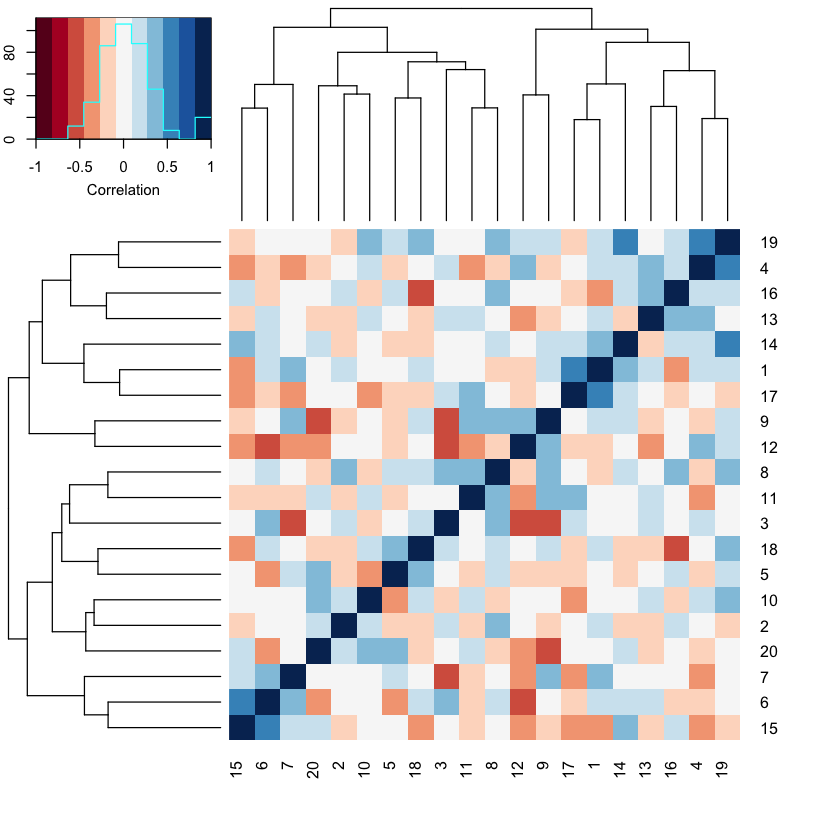

In [13]:
heatmap.2(cor(data$X),col = brewer.pal(11,"RdBu"), trace = "none", 
          key.title = NA, key.ylab = NA, key.xlab = "Correlation")

Notice that there are a lot of non-zero off diagonal values in this correlation matrix. This means that there is rich correlational structure in $X$ as expected. 

For comparison, take a look at what a full rank version of $X$ looks like.

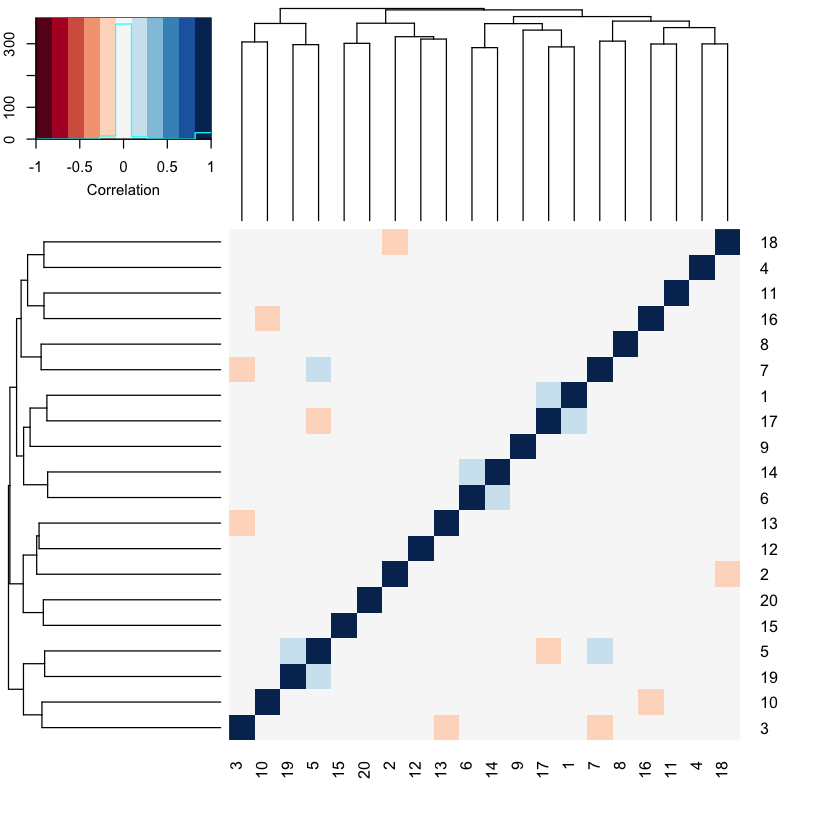

In [23]:
k = p 
data = make_data(n,p,k,s)
heatmap.2(cor(data$X),col=brewer.pal(11,"RdBu"), trace="none", 
          key.title = NA, key.ylab = NA, key.xlab = "Correlation")

Notice the difference? There is very little correlational structure here because each column in $X$ is independent of the other.


Now we want to write a simple loop that uses the built-in `lm` function in R to fit the data that we generate. We already went over this a little bit in previous tutorials. Here we want to focus on how to write a simple loop that generates a training and test data set for different values of $p$. 

This function will be simple. We will generate one large data set ($n*2$ observations) and do a split half test for evaluating both training and test accuracy.

In [24]:
## ------------------------------
# LM split validation function 
## ------------------------------
bv_lm <- function(n, degree, k, s) {
    # Set up the arrays for storing the results
    train_rss = matrix(data=NA, nrow=degree, ncol=1)
    test_rss = matrix(data=NA, nrow=degree, ncol=1)
    p_max = degree[length(degree)]

    # Loop through for each set of p-features
    for (p in degree) {
        # Set up the data, split into training and test
        # sets of size n
        data = make_data(n*2,p_max,k,s)

        train = list(X=data$X[1:n,1:p],Y = data$Y[1:n])
        test = list(X=data$X[(n+1):nrow(data$X),1:p],Y = data$Y[(n+1):nrow(data$X)])

        # Use simple GLM
        lm.fit = lm(Y ~ X, data=train) #, subset=set_id)
    
        # Get your model prediction on both the training
        # and test sets
        yhat_train = predict(lm.fit)
        yhat_test  = predict(lm.fit, newdata=test)

        # Because we get weird outlier predictions plot median sum square error
        train_rss[p-degree[1]+1] = median((train$Y - yhat_train)^2)
        test_rss[p-degree[1]+1] = median((test$Y - yhat_test)^2)
    }
  
    # Store the RSS in a data frame
    out = data.frame(p=degree, train=train_rss, test=test_rss)
}

Notice what this function does. It loops through list called _degrees_ that samples a range of $p$ from that list. Even though the underlying dimensionality is the same.


Okay now we can do one run of this new function to see how it works and plot the results.

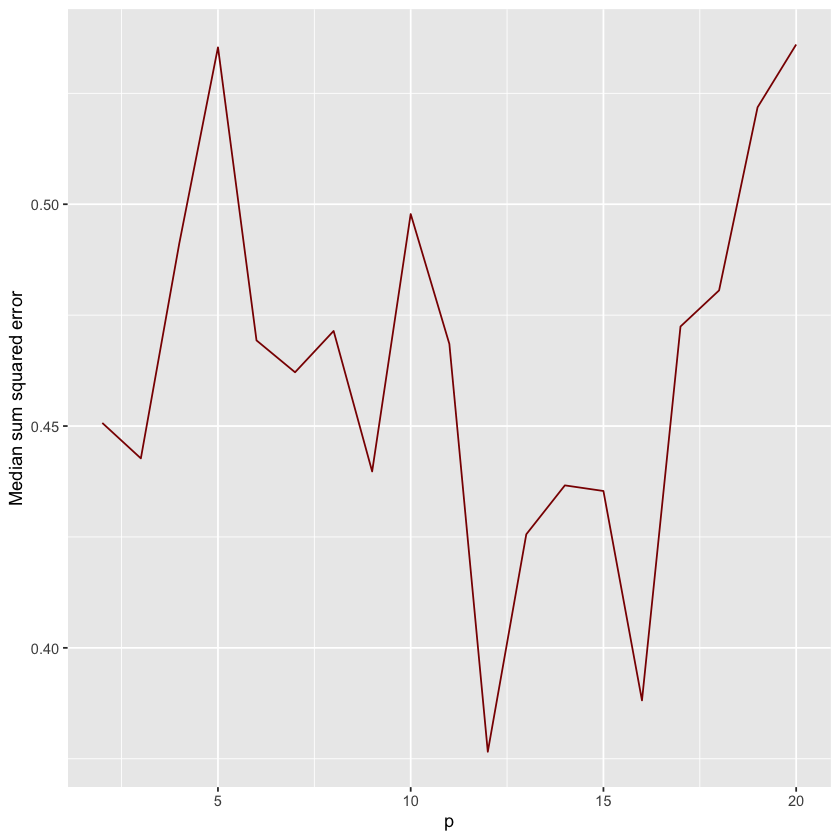

In [28]:
n = 500
k = 10 
s = 20
degree = seq(2,20)

bv_df = bv_lm(n,degree,k, s)

ggplot(bv_df, aes(x=p)) +
  geom_line(aes(y = test), color = "darkred") +
  ylab("Median sum squared error") + xlab("p")

It is noisy, but you should notice that the test error skyrockets as $p$ gets larger. If you squint, somewhere around $p=12$ the test error is minimized. If you run this multiple times, you'll get slightly different plots because the data is getting randomly simulated each time.

But to get a clearer look, let's run a large number of sims and average together.

(This step takes about 10 minutes or so to run if you execute it on your own)

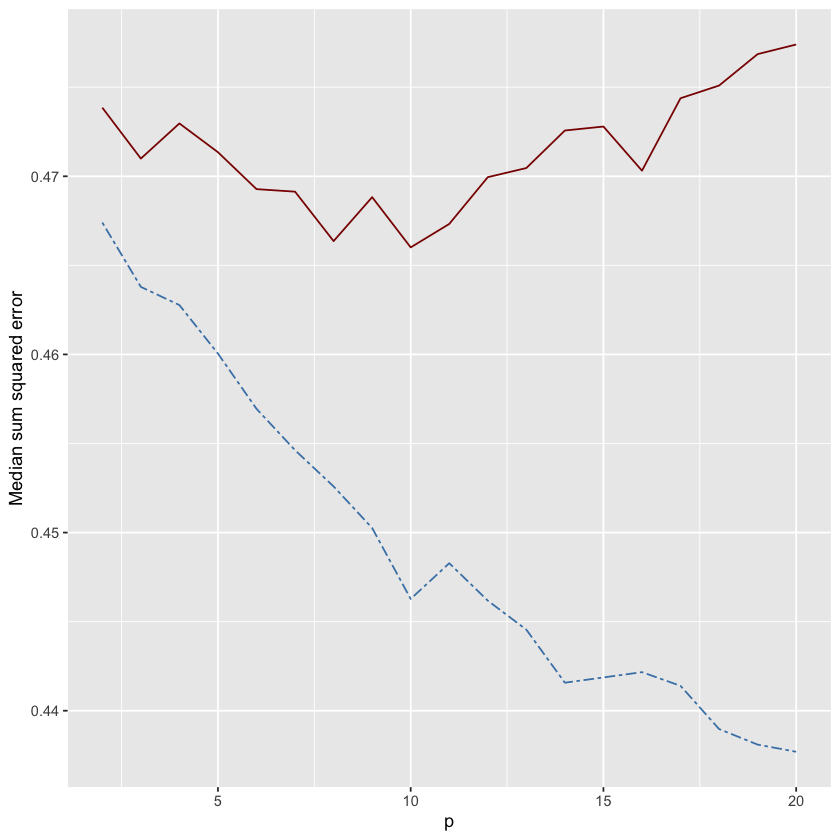

In [29]:
options(warn=-1)

# Parameters
n_iter = 2000
n = 500
k = 10 
s = 20
degree = seq(2,20)

# Aggregated output
train_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)
test_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)

# Loop through n_iter times
for (i in 1:n_iter) {
  bv_df = bv_lm(n,degree,k,s)
  train_rss[,i]=bv_df$train
  test_rss[,i] =bv_df$test
}

# Make a new data frame for plotting
run_df = data.frame(p=degree, train=rowMeans(train_rss), test=rowMeans(test_rss),
                    strain=rowSds(train_rss), stest=rowSds(test_rss))

# Plot
ggplot(run_df, aes(x=p)) +
  geom_line(aes(y = test), color = "darkred") +
  geom_line(aes(y = train), color="steelblue", linetype="twodash") +
   ylab("Median sum squared error") + xlab("p") 


In the plot above, the red line shows the test error and the blue dashed line shows the training error. Notice the classic bias-variance tradeoff where training error continues to decrease as $p$ increases, but test error has a "U" shape that bottoms out close to $p=k$. Classic bias-variance tradeoff.

If you want to have fun with this effect, try changing the value of $k$ in the code cells above and re-running the simulation. What happens?

*Notebook authored by Tim Verstynen and Ven Popov, edited by Krista Bond, Charles Wu, Patience Stevens, Amy Sentis, and Fiona Horner.*